In [1]:
# ! pip install sentence-transformers

In [2]:
import torch
from torch import nn
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from sklearnex import patch_sklearn
# patch_sklearn()
# from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

import gc
import json
import pickle
import numpy as np    
import pandas as pd
from tqdm.notebook import tqdm
# from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-04-18 11:09:17.117816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 11:09:17.117942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 11:09:17.251504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/emotion-dataset/train_file.json
/kaggle/input/emotion-dataset/val_file.json


In [3]:
# /kaggle/input/emotion-dataset/train_file.json

In [4]:
PATH="/kaggle/input/emotion-dataset/"
OUTPATH='/kaggle/working/'
# PATH="D:\\ghd\\NLP-Assignments\\Assignment4\\data\\"
# PATH="data/"
# OUTPATH='output/'
BATCH_SIZE=512
MAX_LENGTH=256
MAX_UTTERANCES=24
ROBERTA_LABELS=100
EPOCHS=25
EOS='</s>'
SEP='[SEP]'
# SOS='o'

torch.manual_seed(0)

model_id = "roberta-base"

In [5]:
device = ""
if torch.cuda.is_available():
    device = "cuda"
    print(torch.cuda.get_device_name(0))
else:
    device = "cpu"

device = torch.device(device)
device

Tesla P100-PCIE-16GB


device(type='cuda')

In [6]:
pad=-100
def get_train(data):
    x=[]
    y=[]
    for row in data:
        speakers=row['speakers']
        emotions=row['emotions']
        utterances=row['utterances']
        triggers=row['triggers']
        # print(speakers,emotions,utterances)
        # trim in front
        while len(utterances)>MAX_UTTERANCES:
            utterances.pop(0)
            speakers.pop(0)
            emotions.pop(0)
            triggers.pop(0)
        
        # print(speakers,emotions,utterances)
        # pad
        while len(utterances)<MAX_UTTERANCES:
            utterances.insert(0,EOS)
            speakers.insert(0,EOS)
            emotions.insert(0,EOS)
            triggers.insert(0,-100)
        # print(speakers[1],emotions[1],utterances[1])
        t=""
        s1=[]
        s2=[]        
        for i in range(MAX_UTTERANCES):
            if(utterances[i]==EOS):
                s1.append(utterances[i])
                s2.append(utterances[i])
                t=EOS
                continue
            if(t==EOS):
                t=""
            # text.append([t,f"{speakers[-1]}:{utterances[-1]}:{emotions[-1]}"])
            s1.append(t)
            s2.append(f"{speakers[-1]}:{utterances[-1]}:{emotions[-1]}")

            t+=f"{speakers[i]}:{utterances[i]}:{emotions[i]} "
        x.append([s1,s2])
        trigs=[]
        for i in triggers:
            if(i is None):
                trigs.append(0)
            else:
                trigs.append(int(i))
        y.append(trigs)
    
    return x,y

def get_eval(data):
    x=[]
    y=[]
    max_len=max([len(i["triggers"]) for i in data])
    # left pad triggers

    for row in data:
        speakers=row['speakers']
        emotions=row['emotions']
        utterances=row['utterances']
        triggers=row['triggers']
        # trim in front
        while len(triggers)>max_len:
            triggers.pop(0)
        # left pad triggers
        while len(triggers)<max_len:
            triggers.insert(0,-100)


        # print(speakers,emotions,utterances)
        # trim in front
        while len(utterances)>MAX_UTTERANCES:
            utterances.pop(0)
            speakers.pop(0)
            emotions.pop(0)
        
        # print(speakers,emotions,utterances)
        # pad
        while len(utterances)<MAX_UTTERANCES:
            utterances.insert(0,EOS)
            speakers.insert(0,EOS)
            emotions.insert(0,EOS)
        # print(speakers[1],emotions[1],utterances[1])
        s1=[]
        s2=[]
        t=""
        for i in range(MAX_UTTERANCES):
            if(utterances[i]==EOS):
                s1.append(utterances[i])
                s2.append(utterances[i])
                t=EOS
                continue
            if(t==EOS):
                t=""
            # text.append([t,f"{speakers[-1]}:{utterances[-1]}:{emotions[-1]}"])
            s1.append(t)
            s2.append(f"{speakers[-1]}:{utterances[-1]}:{emotions[-1]}")
            t+=f"{speakers[i]}:{utterances[i]}:{emotions[i]} "
        x.append([s1,s2])
        trigs=[]
        for i in triggers:
            if(i is None):
                trigs.append(0)
            else:
                trigs.append(int(i))
        y.append(trigs)
    
    return x,y


def load_data(PATH):
    with open(PATH) as f:
        data = json.load(f)
        return data
    
label_encoding = {
    "S":0,
    "surprise":1,
    "fear":2,
    "neutral":3,
    "sadness":4,
    "disgust":5,
    "anger":6,
    "joy":7
}


In [7]:

data = load_data(PATH+"train_file.json")
data_val = load_data(PATH+"val_file.json")
x_train,y_train = get_train(data)
x_val,y_val = get_train(data_val)

In [8]:
x_train[0],y_train[0]

([['</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '',
   'Phoebe:You-you\x85you had sex with Ursula?!:surprise ',
   'Phoebe:You-you\x85you had sex with Ursula?!:surprise Eric:Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and:fear ',
   "Phoebe:You-you\x85you had sex with Ursula?!:surprise Eric:Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and:fear Phoebe:You didn't notice she was wearing different clothes?!:surprise ",
   "Phoebe:You-you\x85you had sex with Ursula?!:surprise Eric:Uh, a little bit. She-she-she walked in and I thought she was you and I kissed her and:fear Phoebe:You didn't notice she was wearing different clothes?!:surprise Eric:Well I was just so excited to see you.:sadness "],
  ['</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '<

In [9]:
max_len=0
for i in range(len(x_train)):
    for j in range(len(x_train[i][0])):
        max_len=max(max_len,len(x_train[i][0][j].split())+len(x_train[i][1][j].split()))
print(max_len)


263


In [10]:
x_val[0],y_val[0]

([['</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '</s>',
   '',
   'Chandler:Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?:anger ',
   "Chandler:Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?:anger Joey:I'd really prefer a mountain bike.:neutral ",
   "Chandler:Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?:anger Joey:I'd really prefer a mountain bike.:neutral Chandler:Janice's birthday is coming up, I want to get her something speacial. Come in here with me.:neutral ",
   "Chandler:Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?:anger Joey:I'd really prefer a mountain bike.:neutral Chandler:Janice's birthday is coming up, I want to get her something speacial. Come in here with me.:neutral Joey:Whoa, whoa, whoa, wait, whoa.:surprise ",
   "Chandler:Hey! Hold on a minute, hold on a second. Do you think these pearls are nice?:anger Joey:I'd really pr

In [11]:
# np.array(x_train).shape

In [12]:
len(x_train),len(y_train),len(x_val),len(y_val)

(6740, 6740, 843, 843)

In [13]:
tokenizer = RobertaTokenizer.from_pretrained(model_id)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
# class

In [15]:
# len(x_train)
# len(x_train[0])
# x_train = np.array(x_train)
# x_train
y_train[0],y_train[4]

([-100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  1,
  1,
  0,
  0,
  0],
 [-100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  0,
  0,
  1])

In [16]:
class Dataset(Dataset):
    def __init__(self, data, tokenizer,labels):
        self.data = data
        self.tokenizer = tokenizer
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
#         print(self.data[idx])
#         dat = "".join(self.data[idx])
        s1,s2 = self.data[idx][0],self.data[idx][1]
        s1_tokenized = self.tokenizer(s1,max_length=MAX_LENGTH,truncation=True,return_tensors="pt",padding="max_length")
        s2_tokenized = self.tokenizer(s2,max_length=MAX_LENGTH,truncation=True,return_tensors="pt",padding="max_length")
        input_ids = torch.cat((s1_tokenized["input_ids"],s2_tokenized["input_ids"]),dim=1).squeeze(0)
        # x_tokenized = self.tokenizer(self.data[idx],max_length=MAX_LENGTH,truncation=True,return_tensors="pt",padding="max_length")
        # input_ids = x_tokenized["input_ids"].squeeze(0)
        # attention_mask = x_tokenized["attention_mask"].squeeze(0)
        return input_ids,torch.tensor(self.labels[idx]).squeeze(0)

In [17]:
train_dataset = Dataset(x_train,tokenizer,y_train)
val_dataset = Dataset(x_val,tokenizer,y_val)

In [18]:
train_dataset[0][0].shape

torch.Size([24, 512])

In [19]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=False)
val_dataloader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [20]:
# class MyModel(nn.Module):
#     def __init__(self, input_size=MAX_LENGTH*2, hidden_size=MAX_UTTERANCES, num_linear_layers=MAX_UTTERANCES, linear_size=2):
#         super(MyModel, self).__init__()
        

#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True, num_layers=2)
        
#         self.linear_layers1 = nn.ModuleList([nn.Linear(hidden_size*2, 128) for _ in range(num_linear_layers)])
#         self.relu = nn.ReLU()
#         self.linear_layers2 = nn.ModuleList([nn.Linear(128, linear_size) for _ in range(num_linear_layers)])
#         # self.softmax_layers = nn.ModuleList([nn.Softmax(dim=1) for _ in range(num_linear_layers)])
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, x):
 
#         for name, param in self.named_parameters():
#             if torch.isnan(param).any():
#                 print(name, "is nan")
#                 os.exit(0)

#         lstm_out, _ = self.lstm(x)

#         # print("Output shape of lstm = ",lstm_out.shape)

#         if(torch.isnan(lstm_out).any()):
#             print("lstm_out is nan"*10)
#             print("NAN "*10)
#             exit(0)
            
#         softmax_outputs = []
#         for i in range(len(self.linear_layers1)):
#             linear_output1 = self.linear_layers1[i](lstm_out[:, -1, :])

#             relu_output = self.relu(linear_output1)

#             linear_output2= self.linear_layers2[i](relu_output)


#             # softmax_output = self.softmax_layers[i](linear_output2)
#             sigmoid_output = self.sigmoid(linear_output2)
#             softmax_outputs.append(sigmoid_output.float())
           
#         stacked_tensor = torch.stack(softmax_outputs, dim=1)
#         return stacked_tensor
# #         return stacked_tensor.clone().detach().requires_grad_(True)

# model = MyModel()
# model.to(device)
# modnum=3
# optim = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0.01)
# scheduler = ReduceLROnPlateau(optim,mode='min', patience=3, factor=0.5)


In [21]:
class MyModel(nn.Module):
    def __init__(self, input_size=MAX_LENGTH*2, hidden_size=MAX_UTTERANCES, num_linear_layers=MAX_UTTERANCES, linear_size=2):
        super(MyModel, self).__init__()
        

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=False, num_layers=2)
        
        self.linear_layers1 = nn.ModuleList([nn.Linear(hidden_size, 128) for _ in range(num_linear_layers)])
        self.relu = nn.ReLU()
        self.linear_layers2 = nn.ModuleList([nn.Linear(128, linear_size) for _ in range(num_linear_layers)])
        # self.softmax_layers = nn.ModuleList([nn.Softmax(dim=1) for _ in range(num_linear_layers)])
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
 
        for name, param in self.named_parameters():
            if torch.isnan(param).any():
                print(name, "is nan")
                os.exit(0)

        lstm_out, _ = self.lstm(x)

        # print("Output shape of lstm = ",lstm_out.shape)

        if(torch.isnan(lstm_out).any()):
            print("lstm_out is nan"*10)
            print("NAN "*10)
            exit(0)
            
        softmax_outputs = []
        for i in range(len(self.linear_layers1)):
            linear_output1 = self.linear_layers1[i](lstm_out[:, -1, :])

            relu_output = self.relu(linear_output1)

            linear_output2= self.linear_layers2[i](relu_output)


            # softmax_output = self.softmax_layers[i](linear_output2)
            sigmoid_output = self.sigmoid(linear_output2)
            softmax_outputs.append(sigmoid_output.float())
           
        stacked_tensor = torch.stack(softmax_outputs, dim=1)
        return stacked_tensor
#         return stacked_tensor.clone().detach().requires_grad_(True)

model = MyModel()
model.to(device)
modnum=3
optim = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0.01)
scheduler = ReduceLROnPlateau(optim,mode='min', patience=3, factor=0.5)


In [22]:
# import torch
# import torch.nn as nn

# class MyModel(nn.Module):
#     def __init__(self, input_size=MAX_LENGTH*2, lstm_hidden_size=256, transformer_hidden_size=512, num_linear_layers=MAX_UTTERANCES, linear_size=2):
#         super(MyModel, self).__init__()
        
#         self.transformer_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=8, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=4)
        
#         # self.lstm = nn.LSTM(transformer_hidden_size, lstm_hidden_size, batch_first=True, bidirectional=True, num_layers=3)
        
#         self.linear_layers1 = nn.ModuleList([nn.Linear(lstm_hidden_size*2, 128) for _ in range(num_linear_layers)])
#         self.relu = nn.Tanh()
#         self.linear_layers2 = nn.ModuleList([nn.Linear(128, linear_size) for _ in range(num_linear_layers)])
#         self.sigmoid = nn.Softmax(dim=1)
    
#     def forward(self, x):

#         # check if nan, 
#         # print(torch.isnan(x).any())

#         for name, param in self.named_parameters():
#             if torch.isnan(param).any():
#                 print(name, "is nan")
#                 os.exit(0)

#         transformer_out = self.transformer_encoder(x)

#         if(torch.isnan(transformer_out).any()):
#             print("transformer_out is nan"*10)
#             print("NAN "*10)
#             os.exit(0)
#             # print(transformer_out)
#         # lstm_out, _ = self.lstm(transformer_out)

#         # if(torch.isnan(lstm_out).any()):
#         #     print("lstm_out is nan"*10)
#         #     print("NAN "*10)
#         #     exit(0)
#         #     # print(lstm_out)

#         # out=lstm_out
#         out=transformer_out
#         # print("Output = ",out)
#         softmax_outputs = []
#         for i in range(len(self.linear_layers1)):
#             linear_output1 = self.linear_layers1[i](out[:, -1, :])
#             # print("linear: ",linear_output1)
#             relu_output = self.relu(linear_output1)
#             linear_output2 = self.linear_layers2[i](relu_output)
#             activation_output = self.relu(linear_output2)
#             sigmoid_output = self.sigmoid(activation_output)
#             softmax_outputs.append(sigmoid_output.float())
           
#         stacked_tensor = torch.stack(softmax_outputs, dim=1)
#         return stacked_tensor


# model = MyModel()
# model.to(device)
# modnum=4
# optim = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0.01)
# scheduler = ReduceLROnPlateau(optim,mode='min', patience=3, factor=0.5)


In [23]:
# import torch
# import torch.nn as nn

# class MyModel(nn.Module):
#     def __init__(self, input_size=MAX_LENGTH*2, lstm_hidden_size=256, transformer_hidden_size=512, num_linear_layers=MAX_UTTERANCES, linear_size=2):
#         super(MyModel, self).__init__()
        
#         self.transformer_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=8, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=4)
        
#         self.lstm = nn.LSTM(transformer_hidden_size, lstm_hidden_size, batch_first=True, bidirectional=True, num_layers=3)
        
#         self.linear_layers1 = nn.ModuleList([nn.Linear(lstm_hidden_size*2, 128) for _ in range(num_linear_layers)])
#         self.relu = nn.Tanh()
#         self.linear_layers2 = nn.ModuleList([nn.Linear(128, linear_size) for _ in range(num_linear_layers)])
#         self.sigmoid = nn.Softmax(dim=1)
    
#     def forward(self, x):

#         # check if nan, 
#         # print(torch.isnan(x).any())

#         for name, param in self.named_parameters():
#             if torch.isnan(param).any():
#                 print(name, "is nan")
#                 os.exit(0)

#         transformer_out = self.transformer_encoder(x)

#         if(torch.isnan(transformer_out).any()):
#             print("transformer_out is nan"*10)
#             print("NAN "*10)
#             os.exit(0)
#             # print(transformer_out)
#         lstm_out, _ = self.lstm(transformer_out)

#         if(torch.isnan(lstm_out).any()):
#             print("lstm_out is nan"*10)
#             print("NAN "*10)
#             exit(0)
#             # print(lstm_out)

#         # out=transformer_out
#         out=lstm_out
#         # print("Output = ",out)
#         softmax_outputs = []
#         for i in range(len(self.linear_layers1)):
#             linear_output1 = self.linear_layers1[i](out[:, -1, :])
#             # print("linear: ",linear_output1)
#             relu_output = self.relu(linear_output1)
#             linear_output2 = self.linear_layers2[i](relu_output)
#             activation_output = self.relu(linear_output2)
#             sigmoid_output = self.sigmoid(activation_output)
#             softmax_outputs.append(sigmoid_output.float())
           
#         stacked_tensor = torch.stack(softmax_outputs, dim=1)
#         return stacked_tensor


# model = MyModel()
# model.to(device)
# modnum=4
# optim = torch.optim.SGD(model.parameters(),lr=0.001,weight_decay=0.01)
# scheduler = ReduceLROnPlateau(optim,mode='min', patience=3, factor=0.5)


In [24]:
model

MyModel(
  (lstm): LSTM(512, 24, num_layers=2, batch_first=True)
  (linear_layers1): ModuleList(
    (0-23): 24 x Linear(in_features=24, out_features=128, bias=True)
  )
  (relu): ReLU()
  (linear_layers2): ModuleList(
    (0-23): 24 x Linear(in_features=128, out_features=2, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [25]:
import torch.nn as nn

criterion = nn.functional.cross_entropy

def metrics(y_true, y_pred):
    acc=accuracy_score(y_true, y_pred)
    f1_macro=f1_score(y_true, y_pred, average='macro')  
    f1_scores=f1_score(y_true, y_pred, average="weighted")
    return acc, f1_macro, f1_scores


In [26]:


def train_epoch(model, optimizer,epoch,val_dataloader,train_dataloader,metrics,weights,scheduler):
    model.train()
    losses = 0
    loss= 0
    preds = []
    actuals = []
    for batch in tqdm(train_dataloader, desc=f"Epoch:{epoch}, train_loss:{loss}",total=len(train_dataloader), leave=False):

        input_ids = batch[0].to(device)
        # attention_mask = batch[1].to(device)
        labels = batch[1].to(device)

        batch_size = input_ids.size(0)
        utt_size = input_ids.size(1)
        # print(input_ids.shape)
        outputs  = model(input_ids.float())
        # print(outputs.shape)
        outputs=outputs.view(batch_size*utt_size,-1)
        labels=labels.view(batch_size*utt_size)
        
        # print(outputs.shape,labels.shape)
        # print(outputs)

        loss = criterion(outputs, labels, weight=weights)

        loss = loss.to(device)
#         print("Loss = ",loss.item)
        losses+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         print(f'Gradient - {name}: {param.grad.norm()}')
    
        _, pred = torch.max(outputs, 1)

        # Flatten the predictions and targets
        predicted_flat = pred.view(-1)
        targets_flat = labels.view(-1)

        preds.extend(predicted_flat.cpu().numpy())
        actuals.extend(targets_flat.cpu().numpy())

        del input_ids
        # del attention_mask
        del labels
        del outputs

        gc.collect()
        torch.cuda.empty_cache()
        # break
#     print("BATCH FINISHED")
    x = losses /len(train_dataloader)
    tqdm.write(f"Epoch:{epoch}, Avg Train Loss: {x}")
    acc,macro,f1 = metrics(actuals,preds)
    tqdm.write(f"Avg Training Accuracy: {acc}, F1 Macro: {macro}, F1 Scores: {f1}")
    val_loss,acc,macro,f1,_ = evaluate(model,val_dataloader,"Validation",metrics,weights)
    scheduler.step(val_loss)
    gc.collect()
    torch.cuda.empty_cache()
    return x,val_loss




def evaluate(model,val_dataloader,name,metric,weights):

    with torch.no_grad():
        model.eval()
        losses = 0

        preds = []
        actuals = []
        for batch in tqdm(val_dataloader, desc=name,total=len(val_dataloader), leave=False):

                input_ids = batch[0].to(device)
                # attention_mask = batch[1].to(device)
                labels = batch[1].to(device)

                batch_size = input_ids.size(0)
                utt_size = labels.size(1)

                outputs  = model(input_ids.float())

                size_diff = labels.size(1) - outputs.size(1)

                # paddings=torch.zeros(batch_size,size_diff,2).to(device)


                # print(outputs.shape,paddings.shape)
                # predicted = torch.cat((outputs,paddings),dim=1)

                predicted=outputs.view(batch_size*utt_size,-1)
                labels=labels.view(batch_size*utt_size)
                
                # print(outputs.shape,labels.shape)
                # loss = criterion(predicted, labels)
                loss = criterion(predicted, labels, weight=weights)


                loss = loss.to(device)
        #         print("Loss = ",loss.item)
                losses+=loss.item()
    
                _, pred = torch.max(predicted, 1)

                # Flatten the predictions and targets
                predicted_flat = pred.view(-1)
                targets_flat = labels.view(-1)

                preds.extend(predicted_flat.cpu().numpy())
                actuals.extend(targets_flat.cpu().numpy())

                del input_ids
                # del attention_mask
                del labels
                del predicted
                # del predicted_labels
                gc.collect()
                torch.cuda.empty_cache()
            # break
        # print(losses,len(val_dataloader))
        x = losses / len(val_dataloader)
        tqdm.write(f"Avg {name} Loss: {x}")
        gc.collect()
        torch.cuda.empty_cache()
        acc,macro,f1 = metric(actuals,preds)
        tqdm.write(f"Avg {name} Accuracy: {acc}, F1 Macro: {macro}, F1 Scores: {f1}")
        return x,acc,macro,f1,preds

In [27]:
# optim = torch.optim.AdamW(model.parameters(),lr=1e-1,weight_decay=0.01)
# scheduler = None

In [28]:
a=0.5
train_loss=[]
eval_loss=[]
weights=torch.tensor([a,1-a]).to(device)
for i in range(1,EPOCHS+1):
    t,e=train_epoch(model,optim,i,val_dataloader,train_dataloader,metrics,weights,scheduler)
    train_loss.append(t)
    eval_loss.append(e)
    if(i%5==0):
        torch.save(model.state_dict(),OUTPATH+f"model_{modnum}_{i}.pth")
    # evaluate(model,val_dataloader,"Validation",metrics)

Epoch:1, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:1, Avg Train Loss: 0.6966294816562107
Avg Training Accuracy: 0.1324245796241345, F1 Macro: 0.12730605305396217, F1 Scores: 0.10741847767013667


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6963565647602081
Avg Validation Accuracy: 0.13508303677342823, F1 Macro: 0.12964360011235418, F1 Scores: 0.11011639545078136


Epoch:2, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:2, Avg Train Loss: 0.6962006986141205
Avg Training Accuracy: 0.13679525222551928, F1 Macro: 0.12984759661116696, F1 Scores: 0.11011730442697805


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6959247291088104
Avg Validation Accuracy: 0.13918544879398972, F1 Macro: 0.13184564553780487, F1 Scores: 0.11260049742792848


Epoch:3, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:3, Avg Train Loss: 0.6957759388855526
Avg Training Accuracy: 0.14149357072205737, F1 Macro: 0.13264093430224974, F1 Scores: 0.11294447324790464


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6954944729804993
Avg Validation Accuracy: 0.14402926057730328, F1 Macro: 0.13462247013632414, F1 Scores: 0.11562674678877134


Epoch:4, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:4, Avg Train Loss: 0.6953524351119995
Avg Training Accuracy: 0.14585187932739863, F1 Macro: 0.13511537334201637, F1 Scores: 0.11543651860662839


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6950695812702179
Avg Validation Accuracy: 0.14916963226571767, F1 Macro: 0.13759898676685872, F1 Scores: 0.11865690084361873


Epoch:5, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:5, Avg Train Loss: 0.6949309578963688
Avg Training Accuracy: 0.15114366963402573, F1 Macro: 0.13815972818343344, F1 Scores: 0.1184325843480592


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6946457624435425
Avg Validation Accuracy: 0.15445828390668248, F1 Macro: 0.14051363938789088, F1 Scores: 0.12147161903950109


Epoch:6, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:6, Avg Train Loss: 0.6945128994328635
Avg Training Accuracy: 0.15677546983184965, F1 Macro: 0.14140106187548693, F1 Scores: 0.12147905364275181


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6942238509654999
Avg Validation Accuracy: 0.16078489521550018, F1 Macro: 0.1441147652276496, F1 Scores: 0.12482826204112822


Epoch:7, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:7, Avg Train Loss: 0.6940970505986895
Avg Training Accuracy: 0.1623763600395648, F1 Macro: 0.14444531243469425, F1 Scores: 0.12444525708434902


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6938035190105438
Avg Validation Accuracy: 0.1664689600632661, F1 Macro: 0.14705084122006482, F1 Scores: 0.127663612574947


Epoch:8, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:8, Avg Train Loss: 0.6936834028788975
Avg Training Accuracy: 0.1686572700296736, F1 Macro: 0.14780629548555568, F1 Scores: 0.1276735003347361


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6933864057064056
Avg Validation Accuracy: 0.17338869118228548, F1 Macro: 0.1510383625316786, F1 Scores: 0.13130198391057074


Epoch:9, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:9, Avg Train Loss: 0.6932723522186279
Avg Training Accuracy: 0.17499381800197825, F1 Macro: 0.15109460497496371, F1 Scores: 0.13091263287913274


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6929716765880585
Avg Validation Accuracy: 0.1793198892843021, F1 Macro: 0.1539521124373563, F1 Scores: 0.13416892812821607


Epoch:10, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:10, Avg Train Loss: 0.6928634899003165
Avg Training Accuracy: 0.18189910979228488, F1 Macro: 0.1546890790327278, F1 Scores: 0.13426990963957794


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6925590336322784
Avg Validation Accuracy: 0.18727758007117437, F1 Macro: 0.15823441952693051, F1 Scores: 0.13800904313319562


Epoch:11, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:11, Avg Train Loss: 0.6924564795834678
Avg Training Accuracy: 0.18940405539070226, F1 Macro: 0.15857962723090943, F1 Scores: 0.13790707451645295


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6921485960483551
Avg Validation Accuracy: 0.1942467378410439, F1 Macro: 0.1616085485814988, F1 Scores: 0.141108897226263


Epoch:12, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:12, Avg Train Loss: 0.6920518236500877
Avg Training Accuracy: 0.19729228486646885, F1 Macro: 0.162631783741605, F1 Scores: 0.14161695892249854


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6917402148246765
Avg Validation Accuracy: 0.20111704230921312, F1 Macro: 0.1649773158686543, F1 Scores: 0.14407297778289158


Epoch:13, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:13, Avg Train Loss: 0.691649351801191
Avg Training Accuracy: 0.20571216617210683, F1 Macro: 0.16680095769025327, F1 Scores: 0.1455595441755536


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6913339197635651
Avg Validation Accuracy: 0.2095689996045868, F1 Macro: 0.16891244036801586, F1 Scores: 0.14780195278153868


Epoch:14, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:14, Avg Train Loss: 0.6912490001746586
Avg Training Accuracy: 0.21416913946587537, F1 Macro: 0.17101517482708603, F1 Scores: 0.14932979390544532


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6909299790859222
Avg Validation Accuracy: 0.21816923685251088, F1 Macro: 0.17315716318917382, F1 Scores: 0.15153998398955607


Epoch:15, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:15, Avg Train Loss: 0.6908507645130157
Avg Training Accuracy: 0.2226879327398615, F1 Macro: 0.17508595187044115, F1 Scores: 0.15308068789640117


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6905280649662018
Avg Validation Accuracy: 0.22518782127323053, F1 Macro: 0.17595304627214145, F1 Scores: 0.15435835052889926


Epoch:16, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:16, Avg Train Loss: 0.6904545766966683
Avg Training Accuracy: 0.2309347181008902, F1 Macro: 0.17888322713990465, F1 Scores: 0.15654563335078112


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6901281177997589
Avg Validation Accuracy: 0.23507315144325822, F1 Macro: 0.18094607687417097, F1 Scores: 0.15850052895938418


Epoch:17, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:17, Avg Train Loss: 0.690060589994703
Avg Training Accuracy: 0.2386807616221563, F1 Macro: 0.18260192446833734, F1 Scores: 0.15966207369367108


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6897302567958832
Avg Validation Accuracy: 0.24199288256227758, F1 Macro: 0.18416112309823304, F1 Scores: 0.16103560318721521


Epoch:18, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:18, Avg Train Loss: 0.6896684552942004
Avg Training Accuracy: 0.24590751730959445, F1 Macro: 0.18614567211845792, F1 Scores: 0.1625300359315595


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.689334511756897
Avg Validation Accuracy: 0.2484677738236457, F1 Macro: 0.18722718920074935, F1 Scores: 0.16355415744429655


Epoch:19, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:19, Avg Train Loss: 0.6892784450735364
Avg Training Accuracy: 0.25217606330365977, F1 Macro: 0.189056125632169, F1 Scores: 0.16487629160736508


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6889404654502869
Avg Validation Accuracy: 0.2542012653222618, F1 Macro: 0.19015791178319355, F1 Scores: 0.16561981668589626


Epoch:20, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:20, Avg Train Loss: 0.6888902315071651
Avg Training Accuracy: 0.25806132542037585, F1 Macro: 0.19206728351122496, F1 Scores: 0.16701288721779756


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.688548743724823
Avg Validation Accuracy: 0.25889679715302494, F1 Macro: 0.19233778739168716, F1 Scores: 0.1670331985916105


Epoch:21, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:21, Avg Train Loss: 0.6885040104389191
Avg Training Accuracy: 0.2631243818001978, F1 Macro: 0.19481289773547186, F1 Scores: 0.16880642730314308


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6881592869758606
Avg Validation Accuracy: 0.2640371688414393, F1 Macro: 0.195382351828338, F1 Scores: 0.16877479076505103


Epoch:22, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:22, Avg Train Loss: 0.6881201309817178
Avg Training Accuracy: 0.2674455984174085, F1 Macro: 0.19730331058015957, F1 Scores: 0.17020891595546542


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.687771737575531
Avg Validation Accuracy: 0.26769474100434953, F1 Macro: 0.19750273342956617, F1 Scores: 0.16978164254250838


Epoch:23, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:23, Avg Train Loss: 0.6877381162984031
Avg Training Accuracy: 0.27151953511374877, F1 Macro: 0.19998961558169495, F1 Scores: 0.17148880114130063


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.687386155128479
Avg Validation Accuracy: 0.2706109134045077, F1 Macro: 0.19871958379536322, F1 Scores: 0.17054362824230843


Epoch:24, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:24, Avg Train Loss: 0.6873581750052316
Avg Training Accuracy: 0.275, F1 Macro: 0.2023322062122841, F1 Scores: 0.17253998036246884


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6870025098323822
Avg Validation Accuracy: 0.2737247924080664, F1 Macro: 0.20090626249215474, F1 Scores: 0.17143146275617793


Epoch:25, train_loss:0:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:25, Avg Train Loss: 0.686980128288269
Avg Training Accuracy: 0.2777818991097923, F1 Macro: 0.20434548298115218, F1 Scores: 0.17331824782666427


Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Validation Loss: 0.6866208016872406
Avg Validation Accuracy: 0.276443258204824, F1 Macro: 0.20287395785407622, F1 Scores: 0.17224457255748207


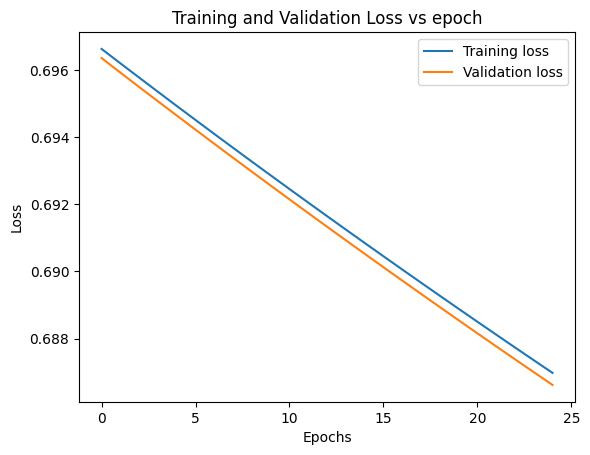

In [29]:
# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs epoch")
plt.legend()
plt.show()

In [30]:
torch.save(model, f"{OUTPATH}modelM{modnum}.pth")
torch.save(tokenizer, f"{OUTPATH}tokenizerM{modnum}.pth")

In [31]:
# load model
loaded_model = torch.load(f"{OUTPATH}modelM3.pth")
loaded_tokenizer = torch.load(f"{OUTPATH}tokenizerM3.pth")
# weights=torch.tensor([0.1,0.9]).to(device)


In [32]:

# test
x_test, y_test = get_train(load_data(PATH+"val_file.json"))



In [33]:
test_dataset = Dataset(x_test,loaded_tokenizer,y_test)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)
loss,acc,macro,f1,preds=evaluate(loaded_model,test_dataloader,"Test",metrics,weights)


Test:   0%|          | 0/2 [00:00<?, ?it/s]

Avg Test Loss: 0.6866208016872406
Avg Test Accuracy: 0.276443258204824, F1 Macro: 0.20287395785407622, F1 Scores: 0.17224457255748207


In [34]:
y_test_list = np.array(y_test).flatten()
preds=np.array(preds).flatten()

In [35]:
dic1={}
dic2={}
for i in range(len(y_test_list)):
    if y_test_list[i] in dic1:
        dic1[y_test_list[i]]+=1
    else:
        dic1[y_test_list[i]]=1
    if preds[i] in dic2:
        dic2[preds[i]]+=1
    else:
        dic2[preds[i]]=1

dic1,dic2

({-100: 12939, 0: 6186, 1: 1107}, {0: 13215, 1: 7017})

In [36]:
p=[]
a=[]
for i in range(len(y_test_list)):
    if(y_test_list[i]!=-100):
        # print(y_test_list[i],preds[i])
        p.append(preds[i])
        a.append(y_test_list[i])

print(classification_report(a,p))
f1_s=f1_score(a,p,average=None)

for label, f1 in enumerate(f1_s):
    print(f"F1 score for label {label}: {f1}")

dic1={}
dic2={}
for i in range(len(p)):
    if p[i] in dic1:
        dic1[p[i]]+=1
    else:
        dic1[p[i]]=1
    if a[i] in dic2:
        dic2[a[i]]+=1
    else:
        dic2[a[i]]=1

dic2,dic1


              precision    recall  f1-score   support

           0       0.86      0.87      0.86      6186
           1       0.22      0.20      0.21      1107

    accuracy                           0.77      7293
   macro avg       0.54      0.54      0.54      7293
weighted avg       0.76      0.77      0.76      7293

F1 score for label 0: 0.8633220775044219
F1 score for label 1: 0.2085661080074488


({0: 6186, 1: 1107}, {1: 1041, 0: 6252})

In [37]:
print(classification_report(y_test_list, preds))
f1_scores = f1_score(y_test_list,preds, average=None)

# Print F1 score for each label
for label, f1 in enumerate(f1_scores):
    print(f"F1 score for label {label}: {f1}")

              precision    recall  f1-score   support

        -100       0.00      0.00      0.00     12939
           0       0.41      0.87      0.55      6186
           1       0.03      0.20      0.06      1107

    accuracy                           0.28     20232
   macro avg       0.15      0.36      0.20     20232
weighted avg       0.13      0.28      0.17     20232

F1 score for label 0: 0.0
F1 score for label 1: 0.5534766249162414
F1 score for label 2: 0.055145248645987195


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
